In [1]:
using MatrixMarket
using LinearAlgebra
using SparseArrays
using Plots
using Printf

# Read the matrix data
file_name = "example_A.mtx"
A_CSC = SparseMatrixCSC{Float64,Int64}( MatrixMarket.mmread(file_name) )
# A is symmetric; we only read the lower triangular part

include("Sparse.jl")
A = SparseMatrixCSR(A_CSC)
n = A.m # Size of matrix

┌ Info: Precompiling MatrixMarket [4d4711f2-db25-561a-b6b3-d35e7d4047d3]
└ @ Base loading.jl:1278


11

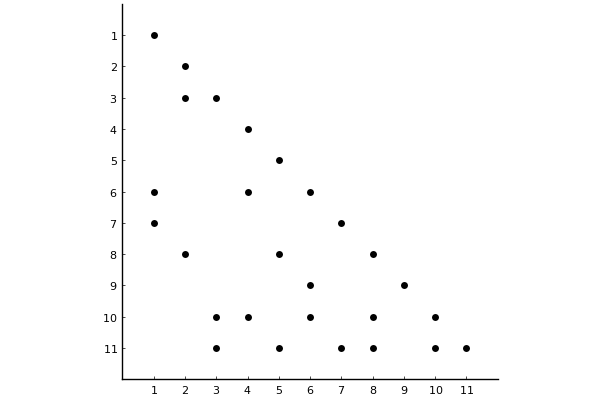

In [2]:
pyplot()
plot(spy(A_CSC), xaxis=((0,n+1), 1:n), yaxis=((0,n+1), 1:n), 
    markersize = 5, clims = (1,2)) 

In [3]:
"""Function that calculates the elimination tree given a CSR structure"""
function etree(rowptr::Vector{Int}, colval::Vector{Int})
    n = length(rowptr) - 1
    parent   = fill(-1,n) # e-tree information
    ancestor = fill(-1,n) # ancestor information to reduce the running time

    # We compute the elimination tree
    for i=1:n
        parent[i]   = -1 # Initialize to -1
        ancestor[i] = -1

        for p = rowptr[i]:rowptr[i+1]-1
            j = colval[p] # column index
            # Traverse row i and stop before the diagonal
            while j != -1 && j < i
                jnext = ancestor[j] # Search for the root
                ancestor[j] = i   # Update ancestor for efficiency
                if jnext == -1    # We have found a root
                    parent[j] = i # Connect to i
                end
                j = jnext
            end
        end
    end
    return parent
end

etree

In [4]:
function row_sparsity(rowptr, colval, parent, i)
    n = length(rowptr) - 1
    s = Vector{Int64}(undef,n)
    w  = fill(false,n) # Used to mark points as visited
    w[i] = true
    len = 1

    for p = rowptr[i]:rowptr[i+1]-1
        j = colval[p] # column index
        # Traverse row i and stop before the diagonal
        while !w[j] && j < i # Stop when marked node is found
            s[len] = j  # Add column j to row i
            w[j] = true # Mark node j
            len += 1
            j = parent[j] # Move to parent in e-tree
        end
    end
        
    len -= 1
    return s[1:len]
end

row_sparsity (generic function with 1 method)

In [5]:
# Compute the elimination tree
parent_tree = etree(A.rowptr, A.colval)

@show parent_tree

# We write the elimination tree to a DOT file.
# Use Graphviz to see the graph of the tree.
# Open the file "etree.dot" using Graphviz.
# http://www.graphviz.org/
# Command line:
# xdot, or
# dot -Tpng etree.dot > etree.png
#
n = A.m # Size of matrix
open("etree.dot", "w") do f
    @printf f "digraph G {\n"
    for k=1:n
        @printf f "%d;\n" k
        if parent_tree[k] != -1
            @printf f "%d -> %d;\n" k parent_tree[k]
        end
    end
    @printf f "label=\"Elimination tree of A\";\n"
    @printf f "labelloc=\"t\";\n"    
    @printf f "}"
end

parent_tree = [6, 3, 8, 6, 8, 7, 9, 10, 10, 11, -1]


In [6]:
n = A.m # Size of matrix

# Select the index of the row subtree
k = 8
@assert k>=1
@assert k<=n

# Compute the row sparsity pattern
s = row_sparsity(A.rowptr, A.colval, parent_tree, k)

# We write the row sub-tree to a DOT file.
# Use Graphviz to see the graph of the row sub-tree.
# Open the file "row_subtree.dot".
open("row_subtree.dot", "w") do f
    @printf f "digraph G {\n"
    @printf f "%d; \n" k
    for i=1:length(s)
        @printf f "%d -> %d;\n" s[i] parent_tree[s[i]]
    end
    @printf f "label=\"Row sub-tree of node %d\";\n" k
    @printf f "labelloc=\"t\";\n"    
    @printf f "}"
end